In [1]:
from OpInf import *
import numpy as np
import scipy
import umap
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from typing import Tuple, List, Dict, Any, NewType

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from itertools import product, combinations

from sklearn.manifold import SpectralEmbedding

from pathlib import Path
import json
import stiefel

import importlib
importlib.reload(stiefel)

from scipy.io import loadmat
from operators import ckron, ckron_indices

import scienceplots
plt.style.use(["science", "no-latex", "grid"])

# set numpy random seed
np.random.seed(3)


check syl solve
True
here
True
6.490991531274637e-14
Use algebraic Stiefel log, metric alpha =  -0.0
dist 3.7699111843077584
NORM TEST1: 0.0
NORM TEST2: 3.9770530618765676e-13
NORM TEST3: 9.900934239137626e-15


In [2]:
def initial_condition(mu, coord):
    if coord <= 0.5:
        return mu * np.sin(2 * np.pi * coord)
    
    return 0

In [3]:
from Representation import *

In [4]:
# mus = [1.1, 1.05, 1, 0.95, 0.9]
# mus = [1.15, 1.1, 1.05, 1, 0.95, 0.9, 0.85]
# mus = [0.4, 0.6, 0.8, 1.0, 1.2]
mus = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
# Load data
T_end_train = 2 
dt= 1e-3
Train_T = int(T_end_train/dt)

# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000.npy")[:, :Train_T+1, :]
# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu1.15_0.85.npy")[:, :Train_T+1, :]
# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu04_12.npy")[:, :Train_T+1, :]
# X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu0.4_0.1_1.2.npy")[:, :Train_T+1, :]
# X_all_test = np.load("../examples/burgers/burgersFEniCSx_u_sol_RE1000_mu0.98.npy")[0]

X_all_nominal = np.load("../examples/burgers/burgersFEniCSx_u_sol_all_RE1000_mu0.4_0.1_1.2_256.npy")[:, :Train_T+1, :]
X_all_test = np.load("../examples/burgers/burgersFEniCSx_u_sol_RE1000_mu0.98_256.npy")[0]

In [5]:
p = 2
Mp = len(mus)
dt = 1e-3
T_end = 2

config = {
    # "N": 2**7 + 1 + 1,
    "N": 2**8 + 1,
    "dt": 1e-3,
    "T_end": T_end,
    "mus": list(mus),
    "Mp": Mp,
    "K": T_end / dt,  # T_end / dt
    "DS": 1,
    "params": {
        "modelform": "LQCP",
        "modeltime": "continuous",
        "dt": dt,
        "ddt_order": "4c",
        "p": p, # polynomial order
        "lambda1": 5e-2,
        "lambda2": 5e-2,
        "lambda3": 100,
    },
    "type": "single"
}




In [6]:
# create simple torch neural network
class Net(nn.Module):
    def __init__(self, r: int, p: int, dim: int = 50):
        super(Net, self).__init__()
        """Simple neural network with 5 hidden layers.
        r is the first r columns of basis matrix V
        p is the next p columns of basis matrix V from r

        Args:
            r (int): Number of first r columns of basis matrix V
            p (int): Number of next p columns of basis matrix V from r
        """
        super(Net, self).__init__()
        self.fc1 = nn.Linear(r, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.fc3 = nn.Linear(dim, dim)
        self.fc4 = nn.Linear(dim, dim)
        self.fc5 = nn.Linear(dim, p)        
        
    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = F.silu(self.fc3(x))
        x = F.silu(self.fc4(x))
        x = self.fc5(x)
            
        return x

In [7]:
# a colors list to tag the group of combinations
colors = plt.get_cmap('tab20').colors

# Create a dictionary to store combinations with their respective colors
tagged_combinations = {}

for r in range(1, len(mus) - 1):
    combinations_ = list(combinations(mus[1:-1], r))
    combinations_ = [(mus[0],) + combo + (mus[-1],) for combo in combinations_]
    print(f"{len(combinations_)} of combinations generated: ", combinations_)
    
    # Ensure that there are enough colors, cycle through colors if necessary
    color = colors[(r - 1) % len(colors)]
    
    # Store the combinations with their tag
    tagged_combinations[color] = combinations_
    
# Flatten the list and maintain the color tagging
flattened_tagged_combinations = [(item, color) for color, combos in tagged_combinations.items() for item in combos]

# Example of accessing the flattened list with color tags
for combo, color in flattened_tagged_combinations:
    print(f"Combination: {combo}, Color: {color}")

7 of combinations generated:  [(0.4, 0.5, 1.2), (0.4, 0.6, 1.2), (0.4, 0.7, 1.2), (0.4, 0.8, 1.2), (0.4, 0.9, 1.2), (0.4, 1.0, 1.2), (0.4, 1.1, 1.2)]
21 of combinations generated:  [(0.4, 0.5, 0.6, 1.2), (0.4, 0.5, 0.7, 1.2), (0.4, 0.5, 0.8, 1.2), (0.4, 0.5, 0.9, 1.2), (0.4, 0.5, 1.0, 1.2), (0.4, 0.5, 1.1, 1.2), (0.4, 0.6, 0.7, 1.2), (0.4, 0.6, 0.8, 1.2), (0.4, 0.6, 0.9, 1.2), (0.4, 0.6, 1.0, 1.2), (0.4, 0.6, 1.1, 1.2), (0.4, 0.7, 0.8, 1.2), (0.4, 0.7, 0.9, 1.2), (0.4, 0.7, 1.0, 1.2), (0.4, 0.7, 1.1, 1.2), (0.4, 0.8, 0.9, 1.2), (0.4, 0.8, 1.0, 1.2), (0.4, 0.8, 1.1, 1.2), (0.4, 0.9, 1.0, 1.2), (0.4, 0.9, 1.1, 1.2), (0.4, 1.0, 1.1, 1.2)]
35 of combinations generated:  [(0.4, 0.5, 0.6, 0.7, 1.2), (0.4, 0.5, 0.6, 0.8, 1.2), (0.4, 0.5, 0.6, 0.9, 1.2), (0.4, 0.5, 0.6, 1.0, 1.2), (0.4, 0.5, 0.6, 1.1, 1.2), (0.4, 0.5, 0.7, 0.8, 1.2), (0.4, 0.5, 0.7, 0.9, 1.2), (0.4, 0.5, 0.7, 1.0, 1.2), (0.4, 0.5, 0.7, 1.1, 1.2), (0.4, 0.5, 0.8, 0.9, 1.2), (0.4, 0.5, 0.8, 1.0, 1.2), (0.4, 0.5, 0.8, 1.1, 1.2), 

[0, 1, 8]
[0, 2, 8]
[0, 3, 8]
[0, 4, 8]
[0, 5, 8]
[0, 6, 8]
[0, 7, 8]
[0, 1, 2, 8]
[0, 1, 3, 8]
[0, 1, 4, 8]
[0, 1, 5, 8]
[0, 1, 6, 8]
[0, 1, 7, 8]
[0, 2, 3, 8]
[0, 2, 4, 8]
[0, 2, 5, 8]
[0, 2, 6, 8]
[0, 2, 7, 8]
[0, 3, 4, 8]
[0, 3, 5, 8]
[0, 3, 6, 8]
[0, 3, 7, 8]
[0, 4, 5, 8]
[0, 4, 6, 8]
[0, 4, 7, 8]
[0, 5, 6, 8]
[0, 5, 7, 8]
[0, 6, 7, 8]
[0, 1, 2, 3, 8]
[0, 1, 2, 4, 8]
[0, 1, 2, 5, 8]
[0, 1, 2, 6, 8]
[0, 1, 2, 7, 8]
[0, 1, 3, 4, 8]
[0, 1, 3, 5, 8]
[0, 1, 3, 6, 8]
[0, 1, 3, 7, 8]
[0, 1, 4, 5, 8]
[0, 1, 4, 6, 8]
[0, 1, 4, 7, 8]
[0, 1, 5, 6, 8]
[0, 1, 5, 7, 8]
[0, 1, 6, 7, 8]
[0, 2, 3, 4, 8]
[0, 2, 3, 5, 8]
[0, 2, 3, 6, 8]
[0, 2, 3, 7, 8]
[0, 2, 4, 5, 8]
[0, 2, 4, 6, 8]
[0, 2, 4, 7, 8]
[0, 2, 5, 6, 8]
[0, 2, 5, 7, 8]
[0, 2, 6, 7, 8]
[0, 3, 4, 5, 8]
[0, 3, 4, 6, 8]
[0, 3, 4, 7, 8]
[0, 3, 5, 6, 8]
[0, 3, 5, 7, 8]
[0, 3, 6, 7, 8]
[0, 4, 5, 6, 8]
[0, 4, 5, 7, 8]
[0, 4, 6, 7, 8]
[0, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 8]
[0, 1, 2, 3, 5, 8]
[0, 1, 2, 3, 6, 8]
[0, 1, 2, 3, 7, 8]
[0, 1, 2, 4, 5, 8]
[0

S =  [169.16588958 126.00022665 100.04889584  66.34007544  48.32450489]
idx =  7
rel_err_SVD[idx] =  0.03650749824756505
X =  (257, 6003)
X_ref =  (257, 1)
S =  [175.18171515 126.15792571 101.85516731  67.94445987  49.4733337 ]
idx =  7
rel_err_SVD[idx] =  0.038522826377843655
X =  (257, 6003)
X_ref =  (257, 1)
S =  [181.89788553 129.04536351 103.95386703  69.91469605  50.65876834]
idx =  7
rel_err_SVD[idx] =  0.03863772898371731
X =  (257, 6003)
X_ref =  (257, 1)
S =  [188.42735207 133.78569541 106.24892494  71.74608666  51.83180406]
idx =  7
rel_err_SVD[idx] =  0.03847583887931638
X =  (257, 6003)
X_ref =  (257, 1)
S =  [194.7174688  139.7664043  108.9131675   73.50311156  53.01341848]
idx =  7
rel_err_SVD[idx] =  0.03813516783599169
X =  (257, 6003)
X_ref =  (257, 1)
S =  [200.7687983  146.67574837 111.84900525  75.21990274  54.20631033]
idx =  7
rel_err_SVD[idx] =  0.03767797416164409
X =  (257, 8004)
X_ref =  (257, 1)
S =  [179.9536447  130.41478827 108.1341101   72.110098    52.4

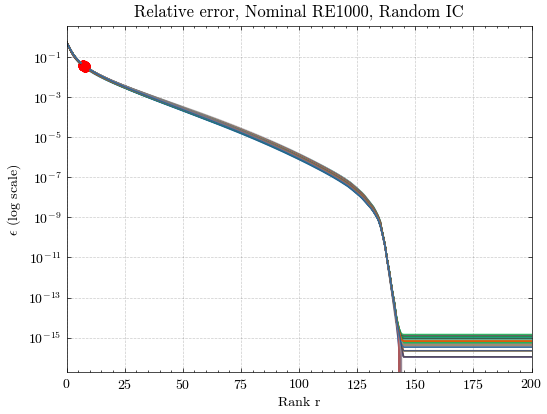

In [8]:
X_nominal = np.concatenate([X for X in X_all_nominal], axis=0).T

# randomly draw 3 ICs (mus) without replacement from X_all_nominal
# X_all_nominals_lst = [X_all_nominal, X_all_nominal_2]
X_list = []
drawn_mus = [tup[0] for tup in flattened_tagged_combinations]
color_tags = []
for n_X in range(len(flattened_tagged_combinations)):
    mus_idx = [mus.index(mus_) for mus_ in flattened_tagged_combinations[n_X][0]]
    print(mus_idx)
    color_tags.append(flattened_tagged_combinations[n_X][1])
    X_list.append(np.concatenate([X_all_nominal[i] for i in mus_idx], axis=0).T)

# X_list.append(X_nominal)
# color_tags.append((0,1,1)) # cyan

rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
# names = [f"tap={taps}" for taps in numtaps] + ["Nominal"]
names = [f"mu={mus}" for mus in drawn_mus] + ["Nominal"]

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 5e-2

# mus = [0.01] # only one mu for now

for i in range(len(X_list)):
    
    X = X_list[i]
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0] + 1
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"{err_tol:.2e} at r={idx}, {names[i]}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal RE1000, Random IC")
    # ax.legend()

In [9]:
# create dataloaders 
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, q: Tensor, qbar: Tensor):
        """Dataset for q and qbar
        
        q and qbar here are transposed to match the shape of the data,
        where each row is a sample corresponding to a time step.

        Args:
            q (Tensor): First r columns of basis matrix V
            qbar (Tensor): Next p columns of basis matrix V from r
        """
        self.q = q.float()
        self.qbar = qbar.float()
        self.mean_q, self.std_q = self.q.mean(0), self.q.std(0)
        self.mean_qbar, self.std_qbar = self.qbar.mean(0), self.qbar.std(0)

    def normalize(self, tensor, mean, std):
        return (tensor - mean) / std

    def denormalize(self, tensor, mean, std):
        return tensor * std + mean

    def __len__(self):
        return len(self.q)

    def __getitem__(self, idx):
        normalized_q = self.normalize(self.q[idx], self.mean_q, self.std_q)
        normalized_qbar = self.normalize(self.qbar[idx], self.mean_qbar, self.std_qbar)
        return normalized_q, normalized_qbar

    def get_original(self, idx):
        return self.q[idx], self.qbar[idx]
    

def relative_err_loss(y_true, y_pred):
    numerator = torch.sum(torch.linalg.norm(y_pred - y_true, axis=1))
    denominator = torch.sum(torch.linalg.norm(y_true, axis=1))
    if denominator == 0:
        return 0
    # print("y_true = ", y_true.shape)
    # print("y_pred = ", y_pred.shape)
    # print("numerator = ", numerator)
    # print("denominator = ", denominator)
    return numerator / denominator

In [10]:
# define device
device = "cuda"

n_epochs = 1000

In [12]:
# Model parameters
# r = np.max(idx_lst)
r = idx_lst[-1]
# q_trunc = 2
# q_trunc = 2
q_trunc = 8
# p = 3

tol = 1e-3      # tolerence for alternating minimization
gamma = 0.01       # regularization parameter\
max_iter = 100  # maximum number of iterations

Vr_lst = []
Vbar_lst = []
Shat_lst = []
Xi_lst = []
Poly_lst = []

for i in range(len(X_list)):
    # Procustes problem for each mu
    X = X_list[i]
    num_snapshots = X.shape[1]
    print("num_snapshots: ", num_snapshots)
    print("X = ", X.shape)
    X_ref = np.mean(X, axis=1)[:, None]
    # X_ref = np.zeros((X.shape[0]))[:, None]
    X_centered = X - X_ref

    U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = U[:, :r]
    Vbar = U[:, r:r + q_trunc]
    q = Vr.T @ X_centered
    qbar = Vbar.T @ X_centered
    
    # create dataloaders train and val using 80/20 split
    q = torch.from_numpy(q).float() if isinstance(q, np.ndarray) else q
    qbar = torch.from_numpy(qbar).float() if isinstance(qbar, np.ndarray) else qbar

    dataset = MyDataset(q.T, qbar.T)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    batch_size = 128

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    model = Net(r, p)
    model.to(device)
    # create base case SGD optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # train the model and evaluate with validation loss at each epoch
    model.train()
    model = torch.compile(model)
    
    for epoch in range(n_epochs):
        
        train_loss = 0
        val_loss = 0
        
        for i, (q_batch, qbar_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            
            q_batch = q_batch.to(device)
            qbar_batch = qbar_batch.to(device)
            
            q_pred = model(q_batch)
            
            print("q_pred = ", q_pred.shape)
            print("qbar_batch = ", qbar_batch.shape)
            
            loss = relative_err_loss(qbar_batch, q_pred)
            loss.backward()
        
            optimizer.step()                
        
            train_loss += loss.item()

        train_loss /= len(train_loader)
        
        model.eval()
        with torch.no_grad():
            for i, (q_batch, qbar_batch) in enumerate(val_loader):
                q_batch = q_batch.to(device)
                qbar_batch = qbar_batch.to(device)
                
                q_pred = model(q_batch)
                val_loss += relative_err_loss(qbar_batch, q_pred).item()
                # print(f"Epoch {epoch}, val_loss: {val_loss / len(val_loader)}")
                # print("Batch ", i, " val_loss: ", relative_err_loss(qbar_batch, q_pred).item())
            val_loss /= len(val_loader)
        
        print(f"Epoch {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")   
    
    # save the model
    torch.save(model.state_dict(), f"../models/NN_model_mu_{mus[i]}.pt")
    
    energy = np.linalg.norm(Vr @ q + (Vbar @ model(q)) + X_ref - X, 'fro')**2 / np.linalg.norm(X - X_ref, 'fro')**2
    
    print(f"Snapshot energy: {energy:e}")

    Gamma_MPOD = X_ref + (Vr @ q) + (Vbar @ model(q))
    print(f"\nReconstruction error: {relative_error(X, Gamma_MPOD, X_ref):.4%}")
    
    Vr_lst.append(Vr)
    Vbar_lst.append(Vbar)
    Shat_lst.append(q)

    # q, energy, Xi, Vr, Vbar, Poly = alternating_minimization(X, X_ref, num_snapshots, max_iter, 1e-3, gamma, r, q, p, initial_Shat=None)

    # print("q = ", q.shape)
    # print("qbar = ", qbar.shape)

num_snapshots:  6003
X =  (257, 6003)


q_pred =  torch.Size([128, 2])
qbar_batch =  torch.Size([128, 8])


RuntimeError: The size of tensor a (2) must match the size of tensor b (8) at non-singleton dimension 1

In [13]:
# Aligning the signs of Vr_lst with Vr_lst[-1]
Vr1 = Vr_lst[-1]
for idx in range(len(Vr_lst) - 1):
    Vr_idx = Vr_lst[idx]
    for j in range(Vr_idx.shape[1]):
        dist1 = np.linalg.norm(Vr1[:, j] - Vr_idx[:, j])
        dist2 = np.linalg.norm(Vr1[:, j] + Vr_idx[:, j])
        if dist2 < dist1:
            Vr_lst[idx][:, j] = -Vr_lst[idx][:, j]

# for i in range(len(Vr_lst) - 1):
#     max_inds = np.argmax(Vr_lst[-1], axis=0) # max indexes for each column corresponding to the largest value in each column
#     for j in range(Vr_lst[i].shape[1]):
#         if np.sign(Vr_lst[i][max_inds[j], j]) != np.sign(Vr_lst[-1][max_inds[j], j]):
#             Vr_lst[i][:, j] = -Vr_lst[i][:, j]

# For Vbar_lst, ensuring sign agreement with Vbar_lst[-1]
Vbar1 = Vbar_lst[-1]
for idx in range(len(Vbar_lst) - 1):
    Vbar_idx = Vbar_lst[idx]
    for j in range(Vbar_idx.shape[1]):
        dist1 = np.linalg.norm(Vbar1[:, j] - Vbar_idx[:, j])
        dist2 = np.linalg.norm(Vbar1[:, j] + Vbar_idx[:, j])
        if dist2 < dist1:
            Vbar_lst[idx][:, j] = -Vbar_lst[idx][:, j]   

In [14]:
V_combined_lst = [np.concatenate([Vr, Vbar], axis=1) for Vr, Vbar in zip(Vr_lst, Vbar_lst)]

# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst], axis=1)
flat_V_combined_arr = np.concatenate([rob.flatten()[:, None] for rob in V_combined_lst], axis=1)

# colors = 
colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst)))


# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(flat_Vr_arr.T)
embedding_Vbar = embedder.fit_transform(flat_Vbar_arr.T)

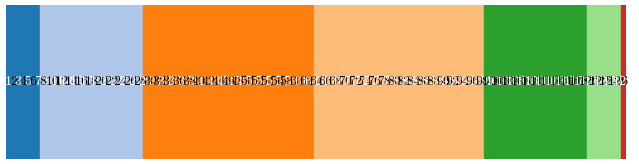

In [15]:
# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust the figure size as needed

# Loop through the colors and plot each one as a rectangle
for i, color in enumerate(color_tags):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.text(i + 0.5, 0.5, str(i + 1), color='white' if i % 2 == 0 else 'black',
            horizontalalignment='center', verticalalignment='center')

# Set limits and remove axes for better visualization
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis('off')

# Show the plot
plt.show()

In [16]:
import importlib
import OpInf
# import reloading
# reload the whole OpInf module
importlib.reload(OpInf)
from OpInf import *


config['robparams'] = {
    "r": int(r)
}

operators_lst = []

# use each mu in between the min and max mu
for i in range(len(X_list)):
    # X = X_list[i]
    # num_snapshots = X.shape[1]
    # print("num_snapshots: ", num_snapshots)
    # print("X = ", X.shape)
    
    mu_test = mus[2]
    
    X = X_list[i]
    X_ref = np.mean(X, axis=1)[:, None]
    X_centered = X - X_ref

    # U, S, Vr = np.linalg.svd(X_centered, full_matrices=False)
    
    Vr = Vr_lst[i]
    Vbar = Vbar_lst[i]
    q = Vr.T @ X_centered

    Mp = len(drawn_mus[i])
    print("Mp: ", Mp)
    
    Nsnapshots = X.shape[1]
    print("Nsnapshots: ", Nsnapshots)
    
    dShatdt = []
    Shat_lst = []
    dSdt = []
    for j in range(Mp):
        start_ind = int((j) * Nsnapshots/Mp)
        end_ind = int((j+1) * Nsnapshots/Mp)
        print("start_ind: ", start_ind)
        print("end_ind: ", end_ind)
        ddtshat, ind = ddt(q[:, start_ind:end_ind], dt=dt, scheme='4c')
        ddts, ind = ddt(X[:, start_ind:end_ind], dt=dt, scheme="4c")
        dShatdt.append(ddtshat)
        ind = np.array(ind) + int((j) * Nsnapshots/Mp)
        Shat_lst.append(q[:, ind])
        dSdt.append(ddts)

    # update config file with truncation order r
    config['robparams'] = {
        "r": int(r)
    }

    Shat_py = np.concatenate(Shat_lst, axis=1)
    dShatdt_py = np.concatenate(dShatdt, axis=1).T
    dSdt_py = np.hstack(dSdt)

    print("Shape of Shat_py: ", Shat_py.shape)
    print("Shape of dShatdt_py: ", dShatdt_py.shape)


    N = int(config['N'])
    dt = config['dt']
    T_end = config['T_end']
    K = int(config['K'])
    DS = config['DS']
    params = config['params']  # This will be a dictionary in Python
    robparams = config['robparams']  # This will be a dictionary in Python


    coord = np.linspace(0, 1, N)
    print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    time_domain = np.arange(0, T_end, dt)
    train_size = Shat_py.shape[1] // len(mus)
    
    print("Train size: ", train_size)

    Shat_true = Shat_lst[2]
    # regs_product = [1e-3, 1e1, 3, 1e1, 1e4, 10, 1e1, 1e7, 7]

    # regs_product = [10, 10, 1, 43.939705607607905, 43.939705607607905, 1, 27.825594022071257, 27.825594022071257, 1] # for r=5
    # regs_product = [1e-1, 1e-1, 1, 1, 1000, 5, 1000, 100000, 3]
    # regs_product = [1e-1, 1e-1, 1, 300, 300, 1, 100000, 100000, 1] # r =8, 5e-2
    regs_product = [1e-1, 1e-1, 1, 4000, 4000, 1, 1000000, 1000000, 1] # r =5, 1e-1
    # regs_product = [1e-1, 1e-1, 1, 1e-1, 1e-1, 1, 10000, 10000, 1]
    # regs_product = [10, 10, 1, 129.1549665014884, 129.1549665014884, 1, 1000000, 1000000, 1] # for r=12

    regs, errors = train_gridsearch(Shat_py, dShatdt_py, Shat_true, train_size, r, regs_product, time_domain, q0, params, testsize=None, margin=1.1)
    
    print(f"Regularization params: {regs}, \t Error: {errors}")
    
    params['lambda1'] = regs[0]
    params['lambda2'] = regs[1]
    if len(regs) > 2:
        params['lambda3'] = regs[2]

    operators = infer_operators_nl(Shat_py, None, config['params'], dShatdt_py)
    
    operators_lst.append(operators)


Mp:  3
Nsnapshots:  6003
start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
Shape of Shat_py:  (8, 5991)
Shape of dShatdt_py:  (5991, 8)
coord =  (257,)
Train size:  665
Constructing least-squares solver, r=8
TRAINING 1 ROMS
(1/1) Testing ROM with (0.09999999999999999, 4000.0000000000014, 1000000.0)
Generating ghat ...


drp:  100
Obtained data matrix...
Regularization parameters:  0.09999999999999999 4000.0000000000014 1000000.0
Solving...
Solved!
Integrating...
Bound check passed
Regularization params: [0.09999999999999999, 4000.0000000000014, 1000000.0], 	 Error: 0.9308213165013657
Generating ghat ...
drp:  100
Obtained data matrix...
Regularization parameters:  0.09999999999999999 4000.0000000000014 1000000.0
Solving...
Solved!
Mp:  3
Nsnapshots:  6003
start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
Shape of Shat_py:  (8, 5991)
Shape of dShatdt_py:  (5991, 8)
coord =  (257,)
Train size:  665
Constructing least-squares solver, r=8
TRAINING 1 ROMS
(1/1) Testing ROM with (0.09999999999999999, 4000.0000000000014, 1000000.0)
Generating ghat ...
drp:  100
Obtained data matrix...
Regularization parameters:  0.09999999999999999 4000.0000000000014 1000000.0
Solving...
Solved!
Integrating...
Bound check passed
Regularization params: [0.09999999999999999, 4000.0000

In [17]:
T_end_index = int(T_end/dt)

# Analyze difference in operators

In [18]:
operators_lst[0].keys()

dict_keys(['A', 'F', 'N', 'B', 'C', 'P'])

In [19]:
# for each operator compute pairwise difference in terms of Frobenius Norm, Spectral Norm, and Eigenvalue distances

operatorsA = []
operatorsF = []
operatorsC = []
operatorsP = []

# Extract matrices from the dictionaries
for dictionary in operators_lst:
    operatorsA.append(dictionary['A'])
    operatorsF.append(dictionary['F'])
    operatorsC.append(dictionary['C'])
    operatorsP.append(dictionary['P'])


# Function to compute the normalized Frobenius norm difference between two matrices
def frobenius_norm_difference(matrix_a, matrix_b):
    norm_a = np.linalg.norm(matrix_a, 'fro')
    norm_b = np.linalg.norm(matrix_b, 'fro')
    diff_norm = np.linalg.norm(matrix_a - matrix_b, 'fro')
    return diff_norm

# Function to compute the normalized Spectral norm difference between two matrices
def spectral_norm_difference(matrix_a, matrix_b):
    norm_a = np.linalg.norm(matrix_a)
    norm_b = np.linalg.norm(matrix_b)
    diff_norm = np.linalg.norm(matrix_a - matrix_b)
    return diff_norm


def pairwise_mat_distances(matrices, norm_function):
    num_matrices = len(matrices)
    
    # Initialize a 2D array with zeros
    pair_dist = np.zeros((num_matrices, num_matrices))
    
    for i in range(num_matrices):
        for j in range(i+1, num_matrices):
            matrix_a = matrices[i]
            matrix_b = matrices[j]
            norm_diff = norm_function(matrix_a, matrix_b)
            # Store the norm difference in the pair_dist array
            pair_dist[i][j] = norm_diff
            pair_dist[j][i] = norm_diff  # Since distance is symmetric
            
    
    # normalize the distance matrix
    max_val = np.max(pair_dist)
    min_val = np.min(pair_dist)
    pair_dist = (pair_dist - min_val) / (max_val - min_val)
    return pair_dist

# Calculate pairwise distances for each type of operator and each norm
operatorsA_frobenius = pairwise_mat_distances(operatorsA, frobenius_norm_difference)
operatorsF_frobenius = pairwise_mat_distances(operatorsF, frobenius_norm_difference)
operatorsC_frobenius = pairwise_mat_distances(operatorsC, frobenius_norm_difference)
operatorsP_frobenius = pairwise_mat_distances(operatorsP, frobenius_norm_difference)

operatorsA_spectral = pairwise_mat_distances(operatorsA, spectral_norm_difference)
operatorsF_spectral = pairwise_mat_distances(operatorsF, spectral_norm_difference)
operatorsC_spectral = pairwise_mat_distances(operatorsC, spectral_norm_difference)
operatorsP_spectral = pairwise_mat_distances(operatorsP, spectral_norm_difference)

# Print or process the resulting distance matrices as needed
print("Pairwise Frobenius distances (A):")
print(operatorsA_frobenius)

print("Pairwise Spectral distances (A):")
print(operatorsA_spectral)

# Repeat for F, C, and P as needed


Pairwise Frobenius distances (A):
[[0.         0.29805102 0.41067287 ... 0.69538626 0.76407314 0.68838305]
 [0.29805102 0.         0.2105536  ... 0.55514941 0.62717799 0.5488329 ]
 [0.41067287 0.2105536  0.         ... 0.44568561 0.52367043 0.46902447]
 ...
 [0.69538626 0.55514941 0.44568561 ... 0.         0.11183269 0.11052143]
 [0.76407314 0.62717799 0.52367043 ... 0.11183269 0.         0.15569776]
 [0.68838305 0.5488329  0.46902447 ... 0.11052143 0.15569776 0.        ]]
Pairwise Spectral distances (A):
[[0.         0.29805102 0.41067287 ... 0.69538626 0.76407314 0.68838305]
 [0.29805102 0.         0.2105536  ... 0.55514941 0.62717799 0.5488329 ]
 [0.41067287 0.2105536  0.         ... 0.44568561 0.52367043 0.46902447]
 ...
 [0.69538626 0.55514941 0.44568561 ... 0.         0.11183269 0.11052143]
 [0.76407314 0.62717799 0.52367043 ... 0.11183269 0.         0.15569776]
 [0.68838305 0.5488329  0.46902447 ... 0.11052143 0.15569776 0.        ]]


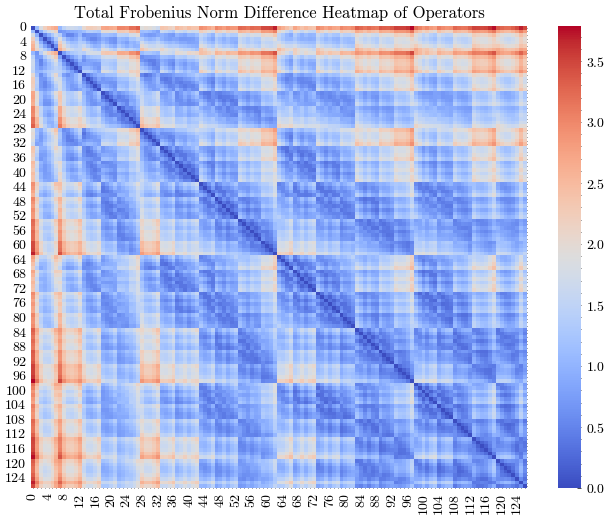

In [20]:
# calculate total frobenius norm of operators
operators_total_frobenius = operatorsA_frobenius + operatorsF_frobenius + operatorsC_frobenius + operatorsP_frobenius

# Create a heatmap to visualize the distance matrix
num_matrices = len(operatorsA)
plt.figure(figsize=(8, 6))
# sns.heatmap(operatorsA_frobenius, annot=True, cmap='coolwarm', xticklabels=[f'Matrix {i+1}' for i in range(num_matrices)], yticklabels=[f'Matrix {i+1}' for i in range(num_matrices)])
sns.heatmap(operators_total_frobenius, cmap='coolwarm')
plt.title('Total Frobenius Norm Difference Heatmap of Operators')
plt.show()

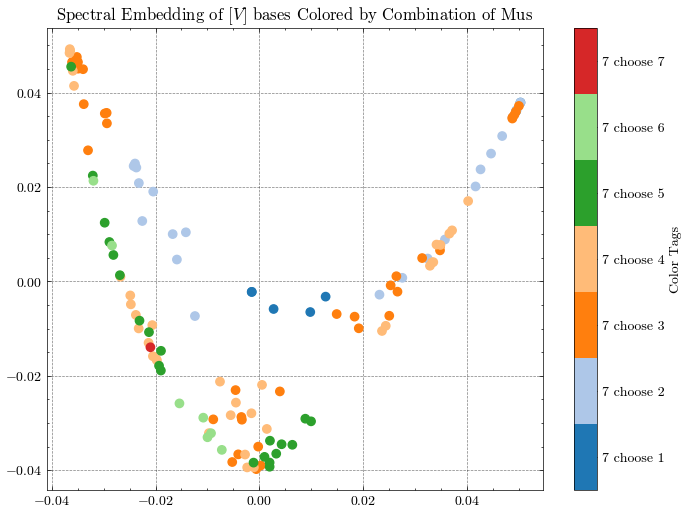

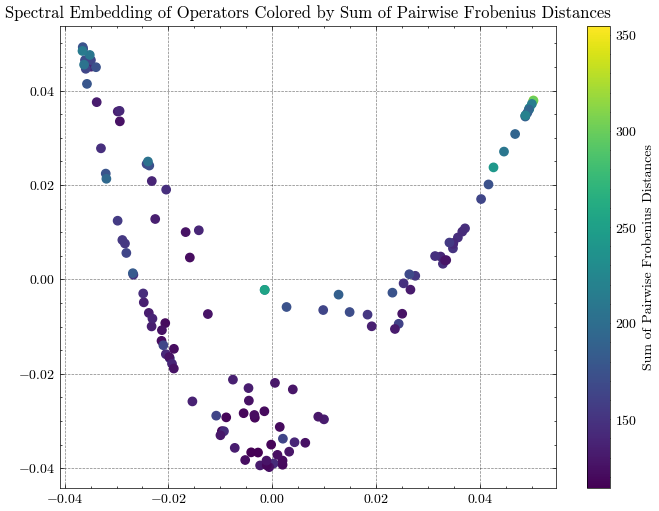

In [21]:
# for each combination, sum the pairwise distances and plot the spectral embedding colored by the sum of pairwise distances
pairwise_sum = operators_total_frobenius.sum(axis=1)
V_combined_embedding = embedder.fit_transform(flat_V_combined_arr.T)

# plot the embedding
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=color_tags)

# Create colorbar
unique_color_tags = []
unique_color_tags.append(color_tags[0])
for i in range(1, len(color_tags)):
    is_unique = True
    for j in range(len(unique_color_tags)):
        if np.array_equal(color_tags[i], unique_color_tags[j]):
            is_unique = False
            break
    if is_unique:
        unique_color_tags.append(color_tags[i])
        
number_of_colors = len(unique_color_tags)
norm = Normalize(vmin=0, vmax=number_of_colors-1)
sm = ScalarMappable(norm=norm, cmap=ListedColormap(unique_color_tags))
sm.set_array([])

cbar = plt.colorbar(sm, ticks=np.arange(number_of_colors), boundaries=np.arange(-0.5, number_of_colors+0.5, 1), ax=ax)
cbar.set_label('Color Tags')
cbar.set_ticks(np.arange(number_of_colors))

# Cbar labels is len(mus) - 2 (excluding the first and last mus) choose r-1
combo_names = [f"{len(mus) - 2} choose {number}" for number in range(1, len(mus) - 1)]
cbar.set_ticklabels([f'{comboname}' for comboname in combo_names])

ax.set_title('Spectral Embedding of $[V]$ bases Colored by Combination of Mus')


fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=pairwise_sum, cmap='viridis')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Sum of Pairwise Frobenius Distances')
ax.set_title('Spectral Embedding of Operators Colored by Sum of Pairwise Frobenius Distances')
plt.show()


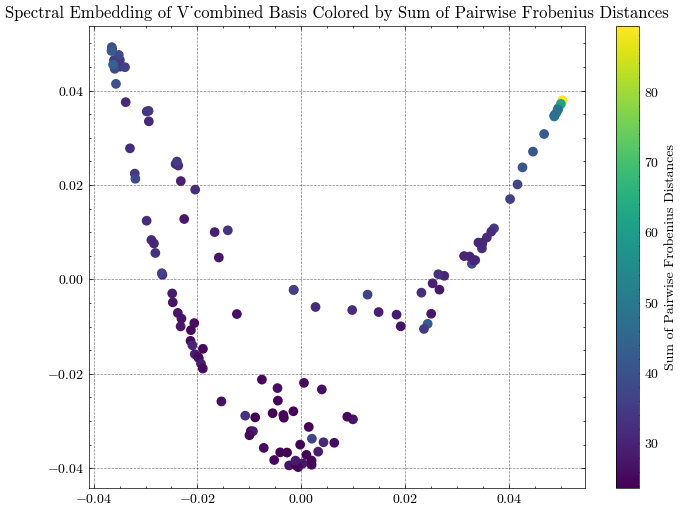

In [22]:
# calculate the normalized frobenius norm difference between the V_combined basis 
V_combined_frobenius = pairwise_mat_distances(V_combined_lst, frobenius_norm_difference)

# plot the spectral embedding of the V_combined basis colored by the normalized frobenius norm difference
V_combined_embedding = embedder.fit_transform(flat_V_combined_arr.T)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=V_combined_frobenius.sum(axis=1), cmap='viridis')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Sum of Pairwise Frobenius Distances')
ax.set_title('Spectral Embedding of V_combined Basis Colored by Sum of Pairwise Frobenius Distances')
plt.show()

In [23]:
# cluster the V_combined embedding
# Clustering
n_clusters = 3  # Number of clusters to ensure distinct outliers
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(V_combined_embedding)

# for each cluster, find the operator with the least total frobenius norm
representatives = []
for i in range(n_clusters):
    cluster_indices = np.where(cluster_labels == i)[0]
    # check if all the selected indices are indeed in the cluster
    cluster_distances = V_combined_frobenius[np.ix_(cluster_indices, cluster_indices)]
    representatives.append(cluster_indices[np.argsort(cluster_distances.sum(axis=1))[0]])

# Check that all representatives belong to the correct cluster
assert np.all(cluster_labels[representatives] == np.arange(n_clusters))

print(f"The representatives for each cluster are at indices: {representatives}")

The representatives for each cluster are at indices: [48, 66, 56]


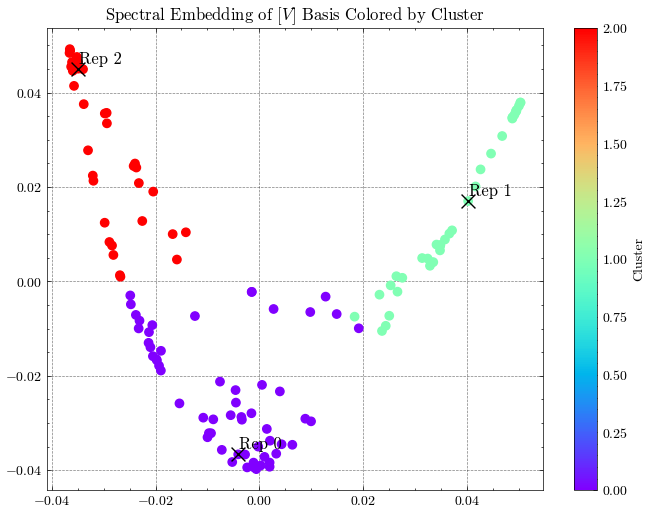

In [24]:
from adjustText import adjust_text
# tag the cluster representatives
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(V_combined_embedding[:, 0], V_combined_embedding[:, 1], c=cluster_labels, cmap='rainbow')
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Cluster')
ax.set_title('Spectral Embedding of $[V]$ Basis Colored by Cluster')
texts = []
for i, txt in enumerate(representatives):
    ax.scatter(V_combined_embedding[txt, 0], V_combined_embedding[txt, 1], c='black', marker='x', s=100)
    text = ax.annotate(f"Rep {i}", (V_combined_embedding[txt, 0], V_combined_embedding[txt, 1]), fontsize=12)
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.show()

# get distinct operators and evaluate

In [25]:
import tqdm

abs_error_full_lst_operators = []
relative_error_testing_window_lst_operators = []
relative_error_training_window_lst_operators = []
s_rec_full_lst_operators = []

mu_test = 0.98

for i in tqdm.tqdm(range(len(X_list)-1)):
    
    operators = operators_lst[i]
    
    X = X_list[i]
    X_ref = np.mean(X, axis=1)[:, None]
    # X_centered = X - X_ref
    
    Vr = Vr_lst[i]
    Vbar = Vbar_lst[i]
    
    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    train_size = Shat_py.shape[1]

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, config['params'], None, multi_indices],  # additional arguments to rhs
            )
    
    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    # Xi = Xi_lst[-1] # the nominal Xi
    Xi = Xi_lst[i]
    # print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr @ s_hat_full + Vbar @ Xi @ poly_full
    
    
    abs_error_full = np.abs(X_all_test.T - s_rec_full)
    relative_error_testing_window = np.linalg.norm(X_all_test.T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_test.T[:, T_end_index:], 'fro')
    relative_error_training_window = np.linalg.norm(X_all_test.T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_test.T[:, :T_end_index], 'fro')
    
    abs_error_full_lst_operators.append(abs_error_full)
    relative_error_testing_window_lst_operators.append(relative_error_testing_window)
    relative_error_training_window_lst_operators.append(relative_error_training_window)
    s_rec_full_lst_operators.append(s_rec_full)
    
    

100%|██████████| 126/126 [00:03<00:00, 35.25it/s]


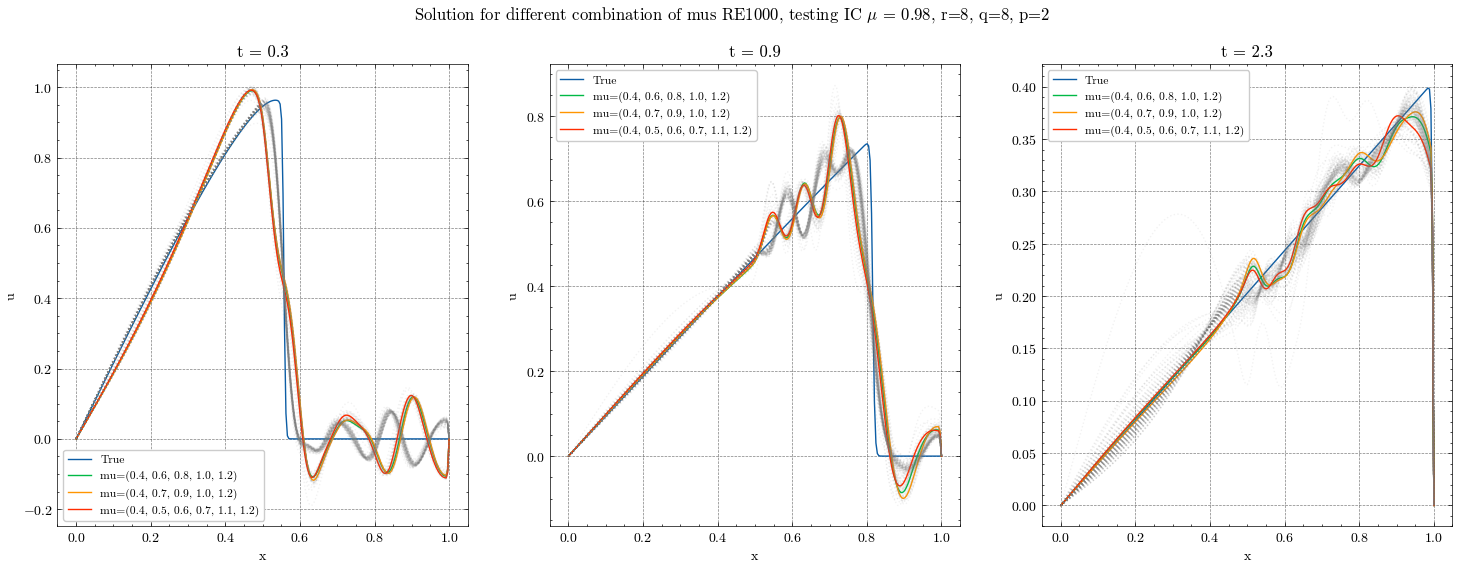

In [26]:
times = [0.3, 0.9, 2.3]

# Example setup (you'll need to define mean_s_rec_full, lower_bound, and upper_bound appropriately)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

colors = plt.cm.tab20(np.linspace(0, 1, len(X_list)))

for i, t in enumerate(times):
    ax = axs[i]
    t_index = int(t / dt)  # Ensure dt is defined and properly calculated

    # Main plot
    x_values = np.linspace(0, 1, s_rec_full_lst_operators[0].shape[0])
    
    ax.plot(x_values, X_all_test.T[:, t_index], label="True", linestyle='-', alpha=1)
    for j in range(len(X_list)-1):
        ax.plot(x_values, s_rec_full_lst_operators[j][:, t_index], linestyle=':', alpha=0.1, color='grey')
        
        if j in representatives:
            ax.plot(x_values, s_rec_full_lst_operators[j][:, t_index], label=names[j], linestyle='-', alpha=1)
            
        # if j in anomalous_idx_iso:
        #     ax.plot(x_values, s_rec_full_lst_operators[j][:, t_index], label=names[j], linestyle='--', alpha=1, color=colors[j])
    
    ax.set_title(f"t = {t}")
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend(loc="best", fontsize='small')
    
plt.suptitle(f"Solution for different combination of mus RE1000, testing IC $\mu$ = 0.98, r={r}, q={q_trunc}, p={p}")
plt.show()


In [27]:
# choose the distinct operators from clustering
V_combined_lst_stochastic = []
Vr_lst_sel = []
Vbar_lst_sel = []

for i in representatives:
    assert(np.allclose(V_combined_lst[i][:, :r], Vr_lst[i]))
    assert(np.allclose(V_combined_lst[i][:, r:], Vbar_lst[i]))
    V_combined_lst_stochastic.append(V_combined_lst[i])
    Vr_lst_sel.append(Vr_lst[i])
    Vbar_lst_sel.append(Vbar_lst[i])    

# X_all_global = np.concatenate([X_list[i] - np.mean(X_list[i], axis=1)[:, None] for i in representatives], axis=1)
X_all_global = np.concatenate([X_list[i] for i in representatives], axis=1)
X_all_global = X_all_global - np.mean(X_all_global, axis=1)[:, None]
V_combined_global = np.linalg.svd(X_all_global, full_matrices=False)[0][:, :r+q_trunc]
V_combined_lst_stochastic.append(V_combined_global)
Vr_lst_sel.append(V_combined_global[:, :r])
Vbar_lst_sel.append(V_combined_global[:, r:])

In [28]:
# now align the signs of Vr_lst_sel with Vr_lst_sel[-1]
Vr1 = Vr_lst_sel[-1]

for idx in range(len(Vr_lst_sel) - 1):
    Vr_idx = Vr_lst_sel[idx]
    for j in range(Vr_idx.shape[1]):
        dist1 = np.linalg.norm(Vr1[:, j] - Vr_idx[:, j])
        dist2 = np.linalg.norm(Vr1[:, j] + Vr_idx[:, j])
        if dist2 < dist1:
            Vr_lst_sel[idx][:, j] = -Vr_lst_sel[idx][:, j]

# Aligning the signs of Vr_lst_sel with Vr_lst_sel[-1]
Vbar1 = Vbar_lst_sel[-1]

for idx in range(len(Vbar_lst_sel) - 1):
    Vbar_idx = Vbar_lst_sel[idx]
    for j in range(Vbar_idx.shape[1]):
        dist1 = np.linalg.norm(Vbar1[:, j] - Vbar_idx[:, j])
        dist2 = np.linalg.norm(Vbar1[:, j] + Vbar_idx[:, j])
        if dist2 < dist1:
            Vbar_lst_sel[idx][:, j] = -Vbar_lst_sel[idx][:, j]

# Aligning signs for V_combined_lst_stochastic
V_combined1 = V_combined_lst_stochastic[-1]

for idx in range(len(V_combined_lst_stochastic) - 1):
    V_combined_idx = V_combined_lst_stochastic[idx]
    for j in range(V_combined_idx.shape[1]):
        dist1 = np.linalg.norm(V_combined1[:, j] - V_combined_idx[:, j])
        dist2 = np.linalg.norm(V_combined1[:, j] + V_combined_idx[:, j])
        if dist2 < dist1:
            V_combined_lst_stochastic[idx][:, j] = -V_combined_lst_stochastic[idx][:, j]
            
assert(np.allclose(V_combined_lst_stochastic[0][:, :r], Vr_lst_sel[0]))

In [29]:
# change the names too
names_sel = [names[i] for i in representatives]
names_sel.append("Global")

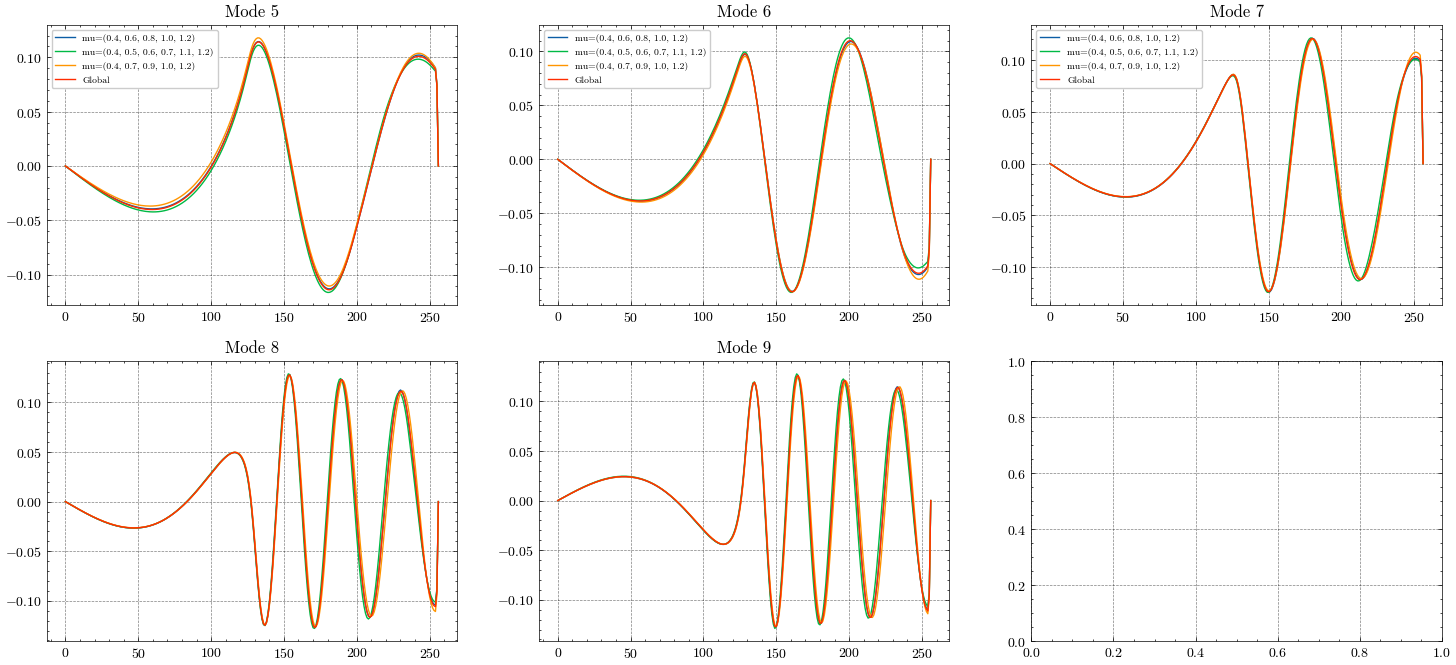

In [30]:
# plot the modes of the aligned signs modes
n_modes_viz = 3
fig, axs = plt.subplots(2, n_modes_viz, figsize=(18, 8))
for i in range(n_modes_viz):
    for j in range(len(V_combined_lst_stochastic)):
        axs[0, i].plot(V_combined_lst_stochastic[j][:, i+3], label=names_sel[j])
        axs[0, i].legend(fontsize='x-small')
    axs[0, i].set_title(f"Mode {i+5}")

for i in range(2):
    for j in range(len(V_combined_lst_stochastic)):
        axs[1, i].plot(V_combined_lst_stochastic[j][:, r + i], label=names_sel[j])
    axs[1, i].set_title(f"Mode {r + i}")

In [31]:
import numpy as np
import itertools
from stiefel import *
import importlib
importlib.reload(stiefel)

N_stiefel_samples = 1000

# the global ROB as reference base point
U0 = V_combined_lst_stochastic[-1]

# number of models excluding the global ROB
num_models = len(V_combined_lst_stochastic) - 1

# rob has shape (num_models, n_points, n), where n_points is the number of points and n is the number of eigenvectors (order of samples)
n_points = V_combined_lst_stochastic[0].shape[0]
n = V_combined_lst_stochastic[0].shape[1]

# get the tangent vectors deltas
tau=0.00001
Deltas = batch_stiefel_log(U0, V_combined_lst_stochastic, tau=tau, metric_alpha=0)

# calculate condiiton number of the matrix H in the quadratic programming problem
X = np.reshape(Deltas[:num_models, :, :], (num_models, -1))
H = X @ X.T

print("Condition number: ", np.linalg.cond(H))

Use algebraic Stiefel log, metric alpha =  0
Use algebraic Stiefel log, metric alpha =  0
Use algebraic Stiefel log, metric alpha =  0
Use algebraic Stiefel log, metric alpha =  0
Condition number:  271.9243015246622


In [32]:
# Generate the samples and split them into two arrays
stiefel_samples_combined, maxI, beta = stiefel.gen_stiefel_samples(N_stiefel_samples, V_combined_lst_stochastic, tau=0.00001, metric_alpha=0.0000000000)

# # Align signs of stiefel samples with global ROB
# for i in range(len(stiefel_samples_combined)):
#     max_inds = np.argmax(V_combined_lst_stochastic[-1], axis=0) # max indexes for each column corresponding to the largest value in each column
#     for j in range(stiefel_samples_combined[i].shape[1]):
#         if np.sign(stiefel_samples_combined[i][max_inds[j], j]) != np.sign(V_combined_lst_stochastic[-1][max_inds[j], j]):
#             stiefel_samples_combined[i][:, j] = -stiefel_samples_combined[i][:, j]

stiefel_samples_Vr = np.array([sample[:, :r] for sample in stiefel_samples_combined])
stiefel_samples_Vbar = np.array([sample[:, r:r+q_trunc] for sample in stiefel_samples_combined])

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jun 12 04:39:53 AM: Your problem has 3 variables, 2 constraints, and 0 parameters.
(CVXPY) Jun 12 04:39:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 12 04:39:53 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 12 04:39:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 12 04:39:53 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation

In [33]:
frechet_mean = calc_frechet_mean_mat(stiefel_samples_combined, V_combined_lst_stochastic[-1], eps=1e-2, tau=1e-3)

Vr_frechet_mean = frechet_mean[0][:, :r]
Vbar_frechet_mean = frechet_mean[0][:, r:+r+q_trunc]

Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic Stiefel log, metric alpha =  0.0
Use algebraic

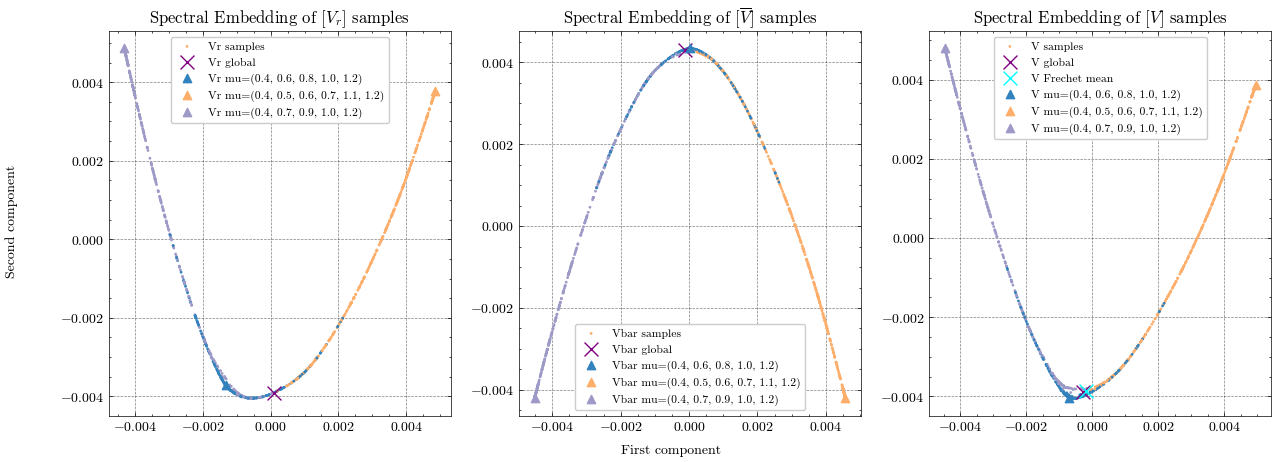

In [34]:
# plot spectral embedding of the generated stiefel sampels
flat_Vr_arr = np.concatenate([rob.flatten()[:, None] for rob in Vr_lst_sel], axis=1)
flat_Vbar_arr = np.concatenate([rob.flatten()[:, None] for rob in Vbar_lst_sel], axis=1)
flat_V_combined_arr_stochastic = np.concatenate([rob.flatten()[:, None] for rob in V_combined_lst_stochastic], axis=1)
flat_Vr_frechet_mean = Vr_frechet_mean.flatten()[:, None]
flat_Vbar_frechet_mean = Vbar_frechet_mean.flatten()[:, None]
rob_Vr_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vr] + [flat_Vr_arr] + [flat_Vr_frechet_mean], axis=1)
rob_Vbar_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_Vbar] + [flat_Vbar_arr] + [flat_Vbar_frechet_mean], axis=1)
rob_V_combined_all = np.concatenate([rob.flatten()[:, None] for rob in stiefel_samples_combined] + [flat_V_combined_arr_stochastic] + [frechet_mean[0].flatten()[:, None]], axis=1)

from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt

colors = plt.cm.tab20c(np.linspace(0, 1, len(Vr_lst_sel)))

# Perform spectral embedding
embedder = SpectralEmbedding(n_components=2)
embedding_Vr = embedder.fit_transform(rob_Vr_all.T)
embedding_Vbar = embedder.fit_transform(rob_Vbar_all.T)
embedding_V_combined = embedder.fit_transform(rob_V_combined_all.T)

# Plot the embeddings
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# plt.scatter(embedding_Vr[:-2, 0], embedding_Vr[:-2, 1], color='grey', s=1, label='Vr samples')
plt.scatter(embedding_Vr[:N_stiefel_samples, 0], embedding_Vr[:N_stiefel_samples, 1], color=colors[maxI], s=1, label='Vr samples')
plt.scatter(embedding_Vr[-2, 0], embedding_Vr[-2, 1], color='purple', label='Vr global', marker='x', s=100)
# plt.scatter(embedding_Vr[-1, 0], embedding_Vr[-1, 1], color='cyan', label='Vr Frechet mean', marker='x', s=100)


for i in range(len(Vr_lst_sel)-1):
    plt.scatter(embedding_Vr[N_stiefel_samples+i, 0], embedding_Vr[N_stiefel_samples+i, 1], color=colors[i], label=f"Vr {names_sel[i]}", marker='^')
    # plt.scatter(embedding_Vr[-i-2, 0], embedding_Vr[-i-2, 1], label=f"Vr {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])

plt.legend(fontsize='small')
plt.title('Spectral Embedding of $[V_r]$ samples')
# plt.xlabel('First component')
# plt.ylabel('Second component')


plt.subplot(1, 3, 2)
plt.scatter(embedding_Vbar[:N_stiefel_samples, 0], embedding_Vbar[:N_stiefel_samples, 1], color=colors[maxI], s=1, label='Vbar samples')
plt.scatter(embedding_Vbar[-2, 0], embedding_Vbar[-2, 1], color='purple', label='Vbar global', marker='x', s=100)
# plt.scatter(embedding_Vbar[-1, 0], embedding_Vbar[-1, 1], color='cyan', label='Vbar Frechet mean', marker='x', s=100)

for i in range(len(Vbar_lst_sel)-1):
    plt.scatter(embedding_Vbar[N_stiefel_samples+i, 0], embedding_Vbar[N_stiefel_samples+i, 1], color=colors[i], label=f"Vbar {names_sel[i]}", marker='^')
    # print(f"Vbar {names_sel[-i-1]}")
    # plt.scatter(embedding_Vbar[-i-2, 0], embedding_Vbar[-i-2, 1], label=f"Vbar {names[-i-1]}, $\\beta$={beta[-1]:.2e}", marker='^', color=colors[i])
    

plt.legend(fontsize='small')
plt.title('Spectral Embedding of $[\overline{V}]$ samples')


plt.subplot(1, 3, 3)
plt.scatter(embedding_V_combined[:N_stiefel_samples, 0], embedding_V_combined[:N_stiefel_samples, 1], color=colors[maxI], s=1, label='V samples')
plt.scatter(embedding_V_combined[-2, 0], embedding_V_combined[-2, 1], color='purple', label='V global', marker='x', s=100)
plt.scatter(embedding_V_combined[-1, 0], embedding_V_combined[-1, 1], color='cyan', label='V Frechet mean', marker='x', s=100)

for i in range(len(V_combined_lst_stochastic)-1):
    plt.scatter(embedding_V_combined[N_stiefel_samples+i, 0], embedding_V_combined[N_stiefel_samples+i, 1], color=colors[i], label=f"V {names_sel[i]}", marker='^')
    # print(f"Vbar {names_sel[-i-1]}")

plt.legend(fontsize='small')
plt.title('Spectral Embedding of $[V]$ samples')
    


# plt.xlabel('First component')
# plt.ylabel('Second component')

# Add common x and y labels
fig.text(0.5, 0.04, 'First component', ha='center', va='center')
fig.text(0.06, 0.5, 'Second component', ha='center', va='center', rotation='vertical')
plt.show()

In [35]:
importlib.reload(stiefel)
from stiefel import *

operators_lst_sel = []
for i in representatives:
    operators_lst_sel.append(operators_lst[i])

In [36]:
X_list_sel = [X_list[i] for i in representatives]
X_ref_lst_sel = [np.mean(X, axis=1)[:, None] for X in X_list_sel]
Vr_lst_sel = [Vr_lst[i] for i in representatives]
Vbar_lst_sel = [Vbar_lst[i] for i in representatives]
Xi_lst_sel = [Xi_lst[i] for i in representatives]

In [37]:
names[representatives[0]]

'mu=(0.4, 0.6, 0.8, 1.0, 1.2)'

In [38]:
import tqdm

N_samples = 1000
abs_error_full_lst = []
relative_error_testing_window_lst = []
relative_error_training_window_lst = []
s_rec_full_lst = []

mu_test = 0.98

for i in tqdm.tqdm(range(N_samples)):
    # # randomly choose 1 from stiefel_samples_Vr and 1 from stiefel_samples_Vbar
    # idx_Vr = np.random.randint(0, N_stiefel_samples)
    # idx_Vbar = np.random.randint(0, N_stiefel_samples)
    
    # print(i)
    
    X = X_list_sel[maxI[i]]
    X_ref = np.mean(X, axis=1)[:, None]
    
    Vr_sample = stiefel_samples_Vr[i]
    Vbar_sample = stiefel_samples_Vbar[i]
    
    operators = operators_lst_sel[maxI[i]]

    coord = np.linspace(0, 1, N)
    # print("coord = ", coord.shape)
    IC = np.array([initial_condition(mu_test, c) for c in coord])
    q0 = Vr_sample.T @ (IC[:, None] - X_ref).flatten()
    
    T_end_full = 8
    time_domain_full = np.arange(0, T_end_full, dt)
    
    train_size = Shat_py.shape[1]

    multi_indices = generate_multi_indices_efficient(len(q0), p=p)
    

    modelform = config['params']['modelform']
    out_full = scipy.integrate.solve_ivp(
                rhs,  # Integrate this function
                [time_domain_full[0], time_domain_full[-1]],  # over this time interval
                q0,  # from this initial condition
                t_eval=time_domain_full,  # evaluated at these points
                args=[operators, config['params'], None, multi_indices],  # additional arguments to rhs
                
            )
    
    s_hat_full = out_full.y
    poly_full = np.concatenate(polynomial_form(s_hat_full, p=p), axis=0)
    # Xi = Xi_lst[-1] # the nominal Xi
    Xi = Xi_lst_sel[maxI[i]]
    # print("Poly shape: ", poly_full.shape)

    s_rec_full = X_ref + Vr_sample @ s_hat_full + Vbar_sample @ Xi @ poly_full
    
    try:
        abs_error_full = np.abs(X_all_test.T - s_rec_full)
        relative_error_testing_window = np.linalg.norm(X_all_test.T[:, T_end_index:] - s_rec_full[:, T_end_index:], 'fro') / np.linalg.norm(X_all_test.T[:, T_end_index:], 'fro')
        relative_error_training_window = np.linalg.norm(X_all_test.T[:, :T_end_index] - s_rec_full[:, :T_end_index], 'fro') / np.linalg.norm(X_all_test.T[:, :T_end_index], 'fro')
        
        abs_error_full_lst.append(abs_error_full)
        relative_error_testing_window_lst.append(relative_error_testing_window)
        relative_error_training_window_lst.append(relative_error_training_window)
        s_rec_full_lst.append(s_rec_full)
        
    except Exception as e:
        print(e)
        print("Error in iteration: ", i)
        continue    

100%|██████████| 1000/1000 [00:28<00:00, 34.92it/s]


In [39]:
# mean relative error across the testing window
mean_relative_error_testing = np.mean(relative_error_testing_window_lst)
std_relative_error_testing = np.std(relative_error_testing_window_lst)
# coeff_var = std_relative_error_testing / mean_relative_error_testing
print(f"Mean relative error: {mean_relative_error_testing:.4%}")
print(f"Std relative error: {std_relative_error_testing:.4%}")
# print(f"Coefficient of variation: {coeff_var:.4%}")

Mean relative error: 36.9359%
Std relative error: 4.6381%


In [40]:
# coefficient of variation of s_rec_full
# coeff_var_s_rec_full = np.std(s_rec_full_lst, axis=0) / (np.mean(s_rec_full_lst, axis=0))
std_s_rec_full = np.std(s_rec_full_lst, axis=0)
std_s_rec_full_testing = std_s_rec_full[:, T_end_index:]
std_s_rec_full_training = std_s_rec_full[:, :T_end_index]

In [41]:
#  mean reconstruction
mean_s_rec_full = np.mean(s_rec_full_lst, axis=0)
mean_s_rec_full_testing = mean_s_rec_full[:, T_end_index:]
mean_s_rec_full_training = mean_s_rec_full[:, :T_end_index]

In [42]:
# calculate 95% confidence interval
confidence_interval = 1.96 * std_s_rec_full

X =  (8000, 257)
Y =  (8000, 257)
s_ref_all[i] =  (257, 6000)


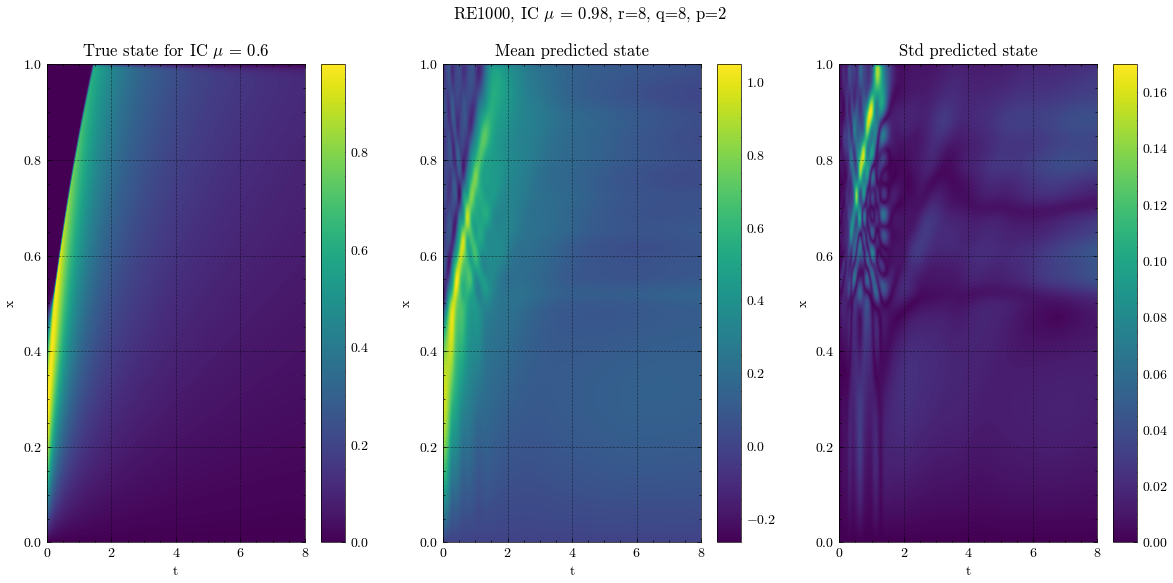

In [43]:
# plot the results side by side
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming s_ref_all is a list of 2D numpy arrays
for i in range(1):
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    XX, YY = np.meshgrid(np.linspace(0.0, T_end_full, int(mean_s_rec_full.shape[0])), np.linspace(0.0, 1.0, mean_s_rec_full.shape[1]))
    print("X = ", XX.shape)
    print("Y = ", YY.shape)
    print("s_ref_all[i] = ", mean_s_rec_full_testing.shape)
    # s = ax.plot_surface(X, Y, s_ref_all[i].reshape(N, int(K+1)), cmap='viridis')
    
    c0 = axs[0].imshow(X_all_test.T, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c0, ax=axs[0], orientation='vertical')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('x')
    axs[0].set_title(f'True state for IC $\mu$ = {mus[2]}')
    
    c1 = axs[1].imshow(mean_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    fig.colorbar(c1, ax=axs[1], orientation='vertical')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('x')
    axs[1].set_title(f'Mean predicted state')
    
    c2 = axs[2].imshow(std_s_rec_full, extent=[np.min(XX), np.max(XX), np.min(YY), np.max(YY)], origin='lower', aspect='auto')
    # c2 = axs[1].imshow(s_rec_all[i].reshape(N, int(K+1)), extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], origin='lower', aspect='auto')
    fig.colorbar(c2, ax=axs[2], orientation='vertical')
    axs[2].set_xlabel('t')
    axs[2].set_ylabel('x')
    axs[2].set_title(f'Std predicted state')
    
    
    # fig.colorbar(c1, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    # fig.colorbar(c2, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.suptitle(f"RE1000, IC $\mu$ = 0.98, r={r}, q={q_trunc}, p={p}")
    plt.tight_layout()
    plt.show()

In [44]:
# find 2 times where there is most uncertainty during training window by quantile
uncertainties_sorted = np.argsort(std_s_rec_full_training.sum(axis=0))

# 

uncertainty_indices = [uncertainties_sorted[-1]]
uncertainty_indices.append(uncertainties_sorted[-100])
# uncertainty_indices = uncertainty_indices.tolist() + [np.argmax(std_s_rec_full_training.sum(axis=0))]
# another time where there is most uncertainty during testing window
uncertainty_indices.append(2300)

In [45]:
uncertainty_indices

[653, 703, 2300]

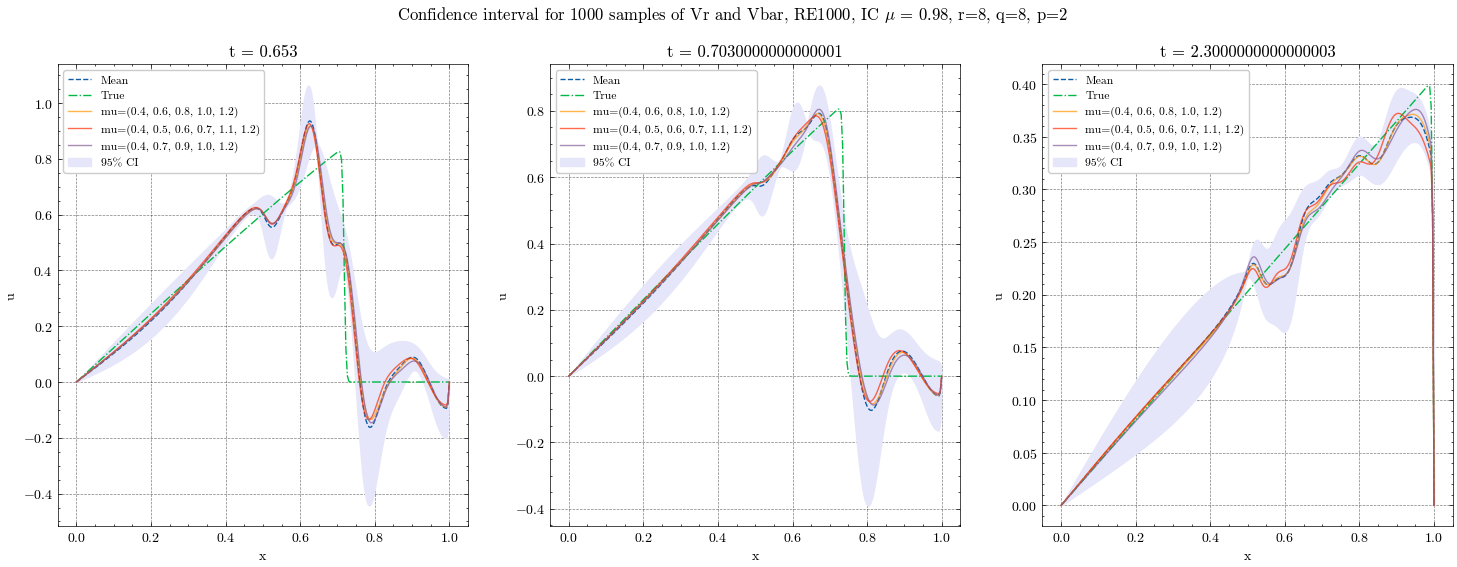

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Example setup (you'll need to define mean_s_rec_full, lower_bound, and upper_bound appropriately)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

upper_bound = mean_s_rec_full + confidence_interval
lower_bound = mean_s_rec_full - confidence_interval

s_rec_full_lst_operators_sel = [s_rec_full_lst_operators[i] for i in representatives]

# for i, t in enumerate(times):
for i, index in enumerate(uncertainty_indices):
    ax = axs[i]
    # t_index = int(t / dt)  # Ensure dt is defined and properly calculated
    t_index = index
    
    t = t_index * dt

    # Main plot
    x_values = np.linspace(0, 1, mean_s_rec_full.shape[0])
    mean_line = mean_s_rec_full[:, t_index]
    # nominal_line = s_rec_full_nominal[:, t_index]
    true_line = X_all_test.T[:, t_index]
    lower_line = lower_bound[:, t_index]
    upper_line = upper_bound[:, t_index]
    
    model_lines = [s_rec_full_lst_operators_sel[j][:, t_index] for j in range(len(s_rec_full_lst_operators_sel))]
    
    ax.plot(x_values, mean_line, label='Mean', linestyle="--")
    ax.plot(x_values, true_line, label='True', linestyle="-.")
    for j in range(len(s_rec_full_lst_operators_sel)):
        ax.plot(x_values, model_lines[j], label=names_sel[j], linestyle="-", alpha=0.7)
    # ax.plot(x_values, nominal_line, label='Nominal', linestyle=":")
    ax.fill_between(x_values, lower_line, upper_line, alpha=1, label='95% CI', color='lavender')
    ax.set_title(f"t = {t}")
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.legend(loc="best", fontsize='small')

    # # Create an inset axis
    # axins = inset_axes(ax, width="25%", height="25%", loc='center right')

    # # Plot the same data on the inset
    # axins.plot(x_values, mean_line, linestyle="--")
    # axins.plot(x_values, true_line, linestyle="-.")
    # axins.plot(x_values, nominal_line, linestyle=":")
    
    # if np.allclose(lower_line, upper_line):
    #     print("Lower and upper bounds are the same")
    #     axins.plot(x_values, lower_line, color='lavender')
    # else:
    #     print("Lower and upper bounds are different")
    #     axins.fill_between(x_values, lower_line, upper_line, color='lavender', alpha=1)

    # # Zoom-in range for the x-axis
    # focus_x_min, focus_x_max = 0.8, 0.81
    # axins.set_xlim(focus_x_min, focus_x_max)
    # axins.set_ylim(np.min(lower_line), np.max(upper_line))

    # # Dynamically determine the y-range based on the focus area
    # mask = (x_values >= focus_x_min) & (x_values <= focus_x_max)
    # focus_y_min = min(np.min(lower_line[mask]), np.min(mean_line[mask]))
    # focus_y_max = max(np.max(upper_line[mask]), np.max(mean_line[mask]))
    # y_margin = (focus_y_max - focus_y_min) * 0.1  # Adjust margin
    # axins.set_ylim(focus_y_min - y_margin, focus_y_max + y_margin)

    # # Optionally remove tick labels to declutter
    # axins.xaxis.set_tick_params(labelbottom=True)
    # axins.yaxis.set_tick_params(labelleft=True)

# plt.tight_layout()
plt.suptitle(f"Confidence interval for 1000 samples of Vr and Vbar, RE1000, IC $\mu$ = 0.98, r={r}, q={q_trunc}, p={p}")
plt.show()


Text(0.5, 0.98, 'Modes of $[V_r]$ and $[\\overline{V}]$ samplesRE1000, r=8, q=8, p=2')

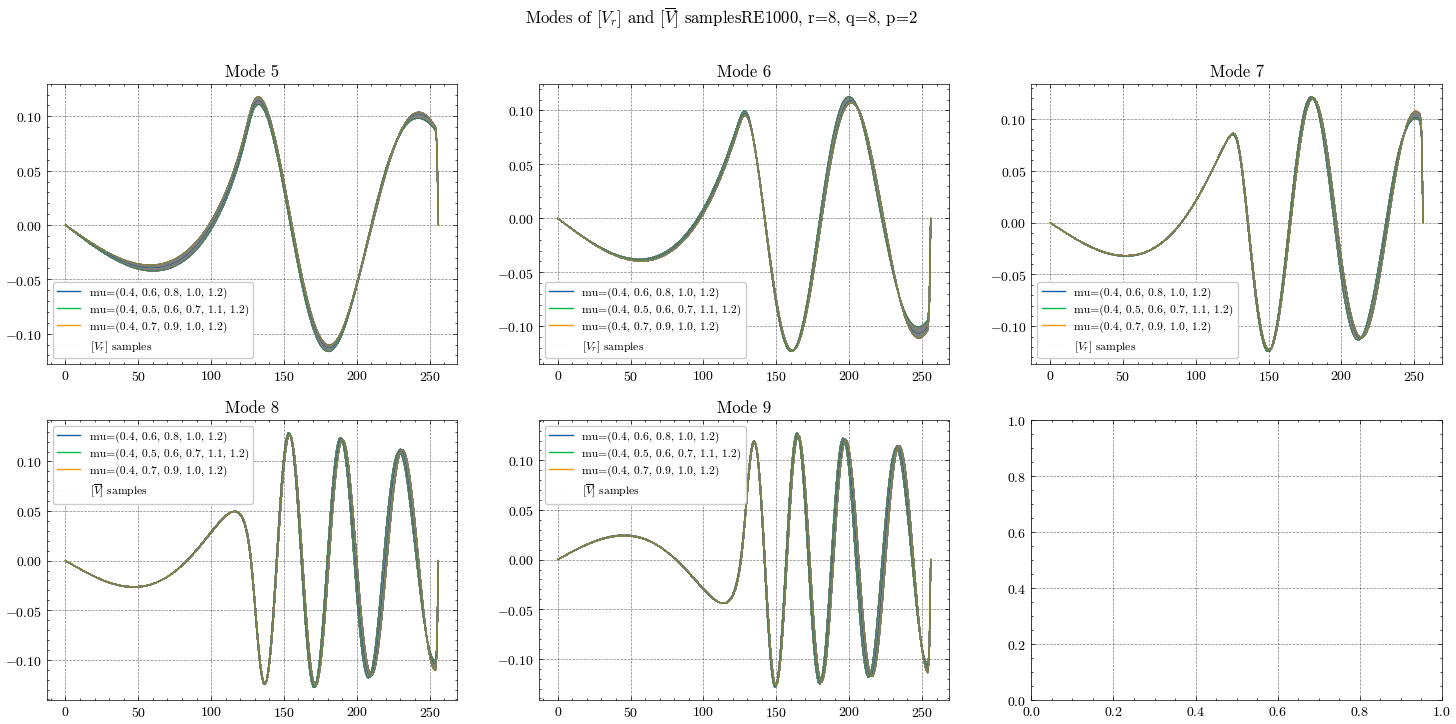

In [47]:
# plot the modes of the samples
n_modes_viz = 3
fig, axs = plt.subplots(2, n_modes_viz, figsize=(18, 8))
for i in range(n_modes_viz):
    lines = []
    for j in range(N_samples):
        y = stiefel_samples_Vr[j][:, i+3]
        x = np.arange(len(y))
        lines.append(list(zip(x, y)))

    lc = LineCollection(lines, colors='grey', alpha=0.02, label='$[V_r]$ samples')
    
    # also plot the modes of the selected bases and the global ROB 
    for j in range(len(Vr_lst_sel)):
        axs[0, i].plot(Vr_lst_sel[j][:, i+3], label=names_sel[j])
    
    axs[0, i].add_collection(lc) 
    axs[0, i].set_title(f"Mode {i+5}")
    axs[0, i].legend(fontsize='small')
    
for i in range(2):
    lines = []
    for j in range(N_samples):
        y = stiefel_samples_Vbar[j][:, i]
        x = np.arange(len(y))
        lines.append(list(zip(x, y)))
    
    lc = LineCollection(lines, colors='grey', alpha=0.02, label='$[\overline{V}]$ samples')
    
    for j in range(len(Vbar_lst_sel)):
        axs[1, i].plot(Vbar_lst_sel[j][:, i], label=names_sel[j])
        
    axs[1, i].add_collection(lc)        
    axs[1, i].set_title(f"Mode {r + i}")
    axs[1, i].legend(fontsize='small')

suptitle = "Modes of $[V_r]$ and $[\overline{V}]$ samples" + f"RE1000, r={r}, q={q_trunc}, p={p}"
plt.suptitle(suptitle)